In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

from env import *
from policy.NN_model import DRL

In [2]:
def train(para, **kw):
    result = {}
    for l in para['range']:
        l = round(l,2)
        nw.clean()
        result[l] = nw.train(para['times'],lambd = l, lr=para['lr'], freq = para['freq'], **kw)
    return result

In [9]:
network = 'topology/6x6.net'
net_name = '6x6'
model = 'DQN'

epsilon = 0
static = True

In [10]:
nw = Network(network, is_drop=False)
nw.agent = DRL(nw, net_name, epsilon=epsilon, static=static)

# network information

In [11]:
print(nw.agent.config)

Network Topology Information
Number of Node: 36
Input dimension 3
-----------------------------------
Hyper Parameter
Learning rate: 4e-05
Reward_decay: 0.99
Memory capacity: 2000
Batch size: 256
Tau: 0.05
-----------------------------------


# Build Neural Network

In [37]:
from policy.network import sxsGAT, sxsDQN
nodes = nw.agent.config.number_of_node
inp = nw.agent.config.node_input
out = nw.agent.config.node_output
eval_net = sxsDQN(nodes, inp, out) if model == 'DQN' else sxsGAT(nodes, inp, out)
target_net = sxsDQN(nodes, inp, out) if model == 'DQN' else sxsGAT(nodes, inp, out)


In [38]:
nw.agent.build_model(eval_net, target_net)

In [39]:
lr = 1e-5
nw.agent.reset_optimizer(lr)
nw.agent.config.memory_capacity = 500
nw.agent.config.batch = 64
nw.agent.build_memory()

In [40]:
print(nw.agent)

Network Topology Information
Number of Node: 36
Input dimension 3
-----------------------------------
Hyper Parameter
Learning rate: 4e-05
Reward_decay: 0.99
Memory capacity: 500
Batch size: 64
Tau: 0.05
-----------------------------------
Memory shape (500, 220)
-----------------------------------
Network shape DQN(
  (fc1): Linear(in_features=108, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=36, bias=True)
)
-----------------------------------
Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
-----------------------------------


# Start Training


In [41]:
DQL = {}
DR = {}

In [42]:
# load trained policy
load = 3.2
nw.agent.load(f'{net_name}/{model}/{load}')

In [ ]:
experiment_range = [1.0, 2.0, 3.0, 2.1, 1.1]

In [43]:
DQL = {}
for i in tqdm(experiment_range):
    for k,v in train({
        'range': [round(i, 2)],
        'times': 5000,
        'lr': {},
        'freq': 1
    }, droprate = True, hop = True).items():
        DQL[i] = v['route_time']
    print(round(i, 2), 'finished and average time is', v['route_time'][-1])

 20%|██        | 1/5 [00:24<01:36, 24.16s/it]

1.0 finished and average time is 5.582543061737953


 40%|████      | 2/5 [00:51<01:15, 25.22s/it]

2.0 finished and average time is 6.415493650949896


 60%|██████    | 3/5 [01:30<00:58, 29.21s/it]

3.0 finished and average time is 8.856866537717602


 80%|████████  | 4/5 [02:18<00:35, 35.02s/it]

2.1 finished and average time is 6.500376293508937


100%|██████████| 5/5 [02:36<00:00, 31.36s/it]

1.1 finished and average time is 5.687031278580575


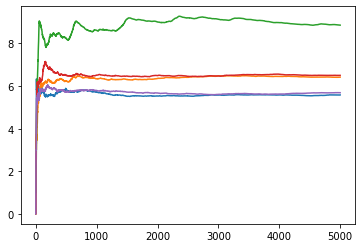

In [44]:
dql = pd.DataFrame(DQL)
plt.plot(dql)
# dql.mean(1).plot()
plt.show()

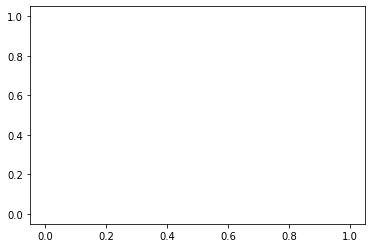

In [45]:
plt.plot(nw.agent.loss)

In [22]:
dql.tail(500).mean()
# plt.savefig('DQN_6x6_1_converge')

2.4    10.958269
2.5    11.155255
2.6    12.640821
2.7    13.916532
2.8    17.480287
2.9    20.995526
dtype: float64

In [19]:
# store_load = 3.2
# nw.agent.store(f'{net_name}/{model}/{store_load}')